In [0]:
from IPython.display import Image

**Word-Level LSTM in PyTorch**
#####In this notebook, I'll construct a word-level LSTM with PyTorch. The network will train word by word on some text, then generate new text word by word

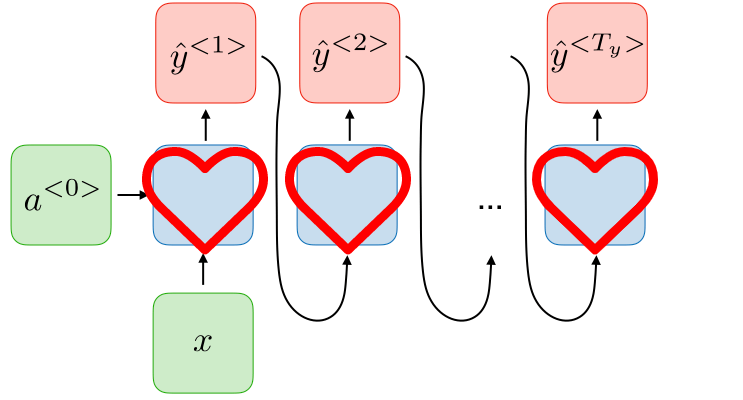

In [77]:
Image('/template.png')

In [0]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

In [0]:
# open text file and read in data as `text`
with open('/test1.txt', 'r') as f:
    text = f.read()

In [38]:
text[:100]

"Doesn't take much to make me happy\nAnd make me smile with glee \nNever never will I feel discouraged "

In [39]:
import re
from string import punctuation
punc= re.compile(r'(\s+|[{}])'.format(re.escape(punctuation)))
print(punc)
words=punc.split(text)
vocab=list(set(words))

re.compile('(\\s+|[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~])')


In [84]:
print(vocab[:50])
int2vocab = dict(enumerate(vocab))
vocab2int = {vc: ii for ii, vc in int2vocab.items()}
# encode the text
encoded = np.array([vocab2int[vc] for vc in words])
print(vocab2int['\n'])
print(encoded[:10])

['', 'pass', 'lottery', 'uh', 'due', 'train', 'dip', 'dime', 'dazed', 'pancakes', 'chose', 'Never', 'Tenement', 'pound', 'stumbled', 'breathe', 'excuses', 'embracin', 'Mmm', 'Brings', 'Burn', 'blankets', 'drinks', 'testify', 'manipulations', 'Tokyo', 'pool', 'smart', 'One', 'Suck', 'happens', 'clovers', 'battle', 'lady', 'Sea', 'vanish', 'ove', 'invade', 'painted', 'Tomorrow', 'enjoyin', 'Lift', 'Change', 'quarter', 'explain', 'fool', 'Bridge', 'Shiawase', 'arise', 'Tap']
487
[ 391 2718 1394 2982 1071 2982 3084 2982 5264 2982]


In [0]:
def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((arr.size, n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

In [8]:
# check that the function works as expected
test_seq = np.array([[0,1,2,3,4,5,6,7,8,9]])
one_hot = one_hot_encode(test_seq, 10)

print(one_hot)

[[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]]


In [0]:
def get_batches(arr, batch_size, seq_length):
    '''Create a generator that returns batches of size
       batch_size x seq_length from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       batch_size: Batch size, the number of sequences per batch
       seq_length: Number of encoded chars in a sequence
    '''
    
    batch_size_total = batch_size * seq_length
    # total number of batches we can make
    n_batches = len(arr)//batch_size_total
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size_total]
    # Reshape into batch_size rows
    arr = arr.reshape((batch_size, -1))
    
    # iterate through the array, one sequence at a time
    for n in range(0, arr.shape[1], seq_length):
        # The features
        x = arr[:, n:n+seq_length]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

In [0]:
batches = get_batches(np.array(encoded), 8, 50)
x, y = next(batches)

In [11]:
# printing out the first 10 items in a sequence
print('x\n', x[:10, :10])
print('\ny\n', y[:10, :10])

x
 [[ 391 2718 1394 2982 1071 2982 3084 2982 5264 2982]
 [5264 2982 4199 2982 3654 2982 2825  487 5033 2982]
 [ 113 2982 1949  487 3879 2982 3654 2982 1311  514]
 [4594  487 5033 2982 1366 2982 3148 2982 1731 2718]
 [5033 2982 1653 2982 4827 2982 5264 2982 5602 2982]
 [3722 2982 1126  487 5033 2982 2152 2982 5033 2982]
 [6183 2982 4105 2982 3654 2982 6292  487 1314 2982]
 [2706 2982 4827  487 5808 2982 5033 2718 3992 2982]]

y
 [[2718 1394 2982 1071 2982 3084 2982 5264 2982 5821]
 [2982 4199 2982 3654 2982 2825  487 5033 2982 1059]
 [2982 1949  487 3879 2982 3654 2982 1311  514    0]
 [ 487 5033 2982 1366 2982 3148 2982 1731 2718    0]
 [2982 1653 2982 4827 2982 5264 2982 5602 2982 4105]
 [2982 1126  487 5033 2982 2152 2982 5033 2982 3178]
 [2982 4105 2982 3654 2982 6292  487 1314 2982 3392]
 [2982 4827  487 5808 2982 5033 2718 3992 2982 5345]]


In [12]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


In [0]:
class WordRNN(nn.Module):
    
    def __init__(self, tokens, n_hidden=512, n_layers=3,
                               drop_prob=0.3, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        # creating words dictionaries
        self.vocab = tokens
        self.int2vocab = dict(enumerate(self.vocab))
        self.vocab2int = {vc: ii for ii, vc in self.int2vocab.items()}
        
        ## TODO: define the LSTM
        self.lstm = nn.LSTM(len(self.vocab), n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        ## TODO: define a dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        ## TODO: define the final, fully-connected output layer
        self.fc1 = nn.Linear(n_hidden, n_hidden*2)
        self.fc2 = nn.Linear(n_hidden*2, len(self.vocab))
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
                
        ## TODO: Get the outputs and the new hidden state from the lstm
        r_output, hidden = self.lstm(x, hidden)

        ## TODO: pass through a dropout layer
        out = self.dropout(r_output)
        
        # Stack up LSTM outputs using view
        # you may need to use contiguous to reshape the output
        out = out.contiguous().view(-1, self.n_hidden)
        
        ## TODO: put x through the fully-connected layer
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        # return the final output and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden
        

In [57]:
net = WordRNN(vocab)
print(net)

WordRNN(
  (lstm): LSTM(6339, 512, num_layers=3, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=512, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=6339, bias=True)
)


In [0]:
opt = torch.optim.RMSprop(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [0]:
def train(net, data, epochs=10, batch_size=10, seq_length=50, lr=0.001, clip=5, val_frac=0.1, print_every=10):
    ''' Training a network 
    
        Arguments
        ---------
        
        net: WordRNN network
        data: text data to train the network
        epochs: Number of epochs to train
        batch_size: Number of mini-sequences per mini-batch, aka batch size
        seq_length: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        print_every: Number of steps for printing training and validation loss
    
    '''
    valid_loss_min = np.Inf

    net.train()
    
    # create training and validation data
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    if(train_on_gpu):
        net.cuda()
    
    counter = 0
    n_vocab = len(net.vocab)
    for e in range(epochs):
        # initialize hidden state
        h = net.init_hidden(batch_size)
        
        for x, y in get_batches(data, batch_size, seq_length):
            counter += 1
            
            # One-hot encode our data and make them Torch tensors
            x = one_hot_encode(x, n_vocab)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            
            if(train_on_gpu):
                inputs, targets = inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            net.zero_grad()
            
            # get the output from the model
            output, h = net(inputs, h)
            
            # calculate the loss and perform backprop
            loss = criterion(output, targets.view(batch_size*seq_length).long())
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()
            
            # loss stats
            if counter % print_every == 0:
                # Get validation loss
                val_h = net.init_hidden(batch_size)
                val_losses = []
                net.eval()
                for x, y in get_batches(val_data, batch_size, seq_length):
                    # One-hot encode our data and make them Torch tensors
                    x = one_hot_encode(x, n_vocab)
                    x, y = torch.from_numpy(x), torch.from_numpy(y)
                    
                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])
                    
                    inputs, targets = x, y
                    if(train_on_gpu):
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output, val_h = net(inputs, val_h)
                    val_loss = criterion(output, targets.view(batch_size*seq_length).long())
                
                    val_losses.append(val_loss.item())
                
                net.train() # reset to train mode after iterationg through validation data
                
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))
                if np.mean(val_losses) <= valid_loss_min:
                    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                    valid_loss_min,
                    np.mean(val_losses)))
                    torch.save(net.state_dict(), 'rnn_love_song.pt')
                    valid_loss_min = np.mean(val_losses)

In [60]:
batch_size = 60
seq_length = 100
n_epochs =  50

# train the model
train(net, encoded, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.001, print_every=50)

Epoch: 1/50... Step: 50... Loss: 4.2597... Val Loss: 4.5345
Validation loss decreased (inf --> 4.534461).  Saving model ...
Epoch: 2/50... Step: 100... Loss: 3.5288... Val Loss: 3.8540
Validation loss decreased (4.534461 --> 3.854010).  Saving model ...
Epoch: 3/50... Step: 150... Loss: 3.5460... Val Loss: 3.7875
Validation loss decreased (3.854010 --> 3.787464).  Saving model ...
Epoch: 4/50... Step: 200... Loss: 3.4537... Val Loss: 3.8069
Epoch: 4/50... Step: 250... Loss: 3.5355... Val Loss: 3.8653
Epoch: 5/50... Step: 300... Loss: 3.5002... Val Loss: 3.7982
Epoch: 6/50... Step: 350... Loss: 3.5318... Val Loss: 3.8503
Epoch: 7/50... Step: 400... Loss: 3.4131... Val Loss: 3.8275
Epoch: 8/50... Step: 450... Loss: 3.4789... Val Loss: 3.8614
Epoch: 8/50... Step: 500... Loss: 3.5223... Val Loss: 3.8098
Epoch: 9/50... Step: 550... Loss: 3.4510... Val Loss: 3.8502
Epoch: 10/50... Step: 600... Loss: 3.3498... Val Loss: 3.8514
Epoch: 11/50... Step: 650... Loss: 3.3016... Val Loss: 3.7534
Vali

KeyboardInterrupt: ignored

In [61]:
net.load_state_dict(torch.load('rnn_love_song.pt'))
net

WordRNN(
  (lstm): LSTM(6339, 512, num_layers=3, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=512, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=6339, bias=True)
)

In [0]:
def predict(net,word, h=None, top_k=None):
        ''' Given a word, predict the next word.
            Returns the predicted word and the hidden state.
        '''
        
        # tensor inputs
        x = np.array([[net.vocab2int[word]]])
        x = one_hot_encode(x, len(net.vocab))
        inputs = torch.from_numpy(x)
        
        if(train_on_gpu):
            inputs = inputs.cuda()
        
        # detach hidden state from history
        h = tuple([each.data for each in h])
        # get the output of the model
        out, h = net(inputs, h)

        # get the word probabilities
        p = F.softmax(out, dim=1).data
        if(train_on_gpu):
            p = p.cpu() # move to cpu
        
        # get top words
        if top_k is None:
            top_ch = np.arange(len(net.vocab))
        else:
            p, top_ch = p.topk(top_k)
            top_ch = top_ch.numpy().squeeze()
        
        # select the likely next words with some element of randomness
        p = p.numpy().squeeze()
        word = np.random.choice(top_ch, p=p/p.sum())
        
        # return the encoded value of the predicted char and the hidden state
        return net.int2vocab[word], h

In [0]:
def sample(net, size, prime='The', top_k=None):
        
    if(train_on_gpu):
        net.cuda()
    else:
        net.cpu()
    
    net.eval() # eval mode
    
    # First off, run through the prime characters
    punc= re.compile(r'(\s+|[{}])'.format(re.escape(punctuation)))
    words=punc.split(prime)

    h = net.init_hidden(1)
    for wd in words:
        word, h = predict(net, wd.strip(), h, top_k=top_k)

    words.append(" "+word)
    # Now pass in the previous character and get a new one
    for ii in range(size):
        word, h = predict(net, words[-1].strip(), h, top_k=top_k)
        words.append(" "+word)

    return ''.join(words)

In [71]:
# Sample using a loaded model
print(sample(net, 8000, top_k=5, prime="love"))

love   to   me   to   me 

 on   my   eyes ,    ride 
 make   me   feel   my   soul   on   away 
 on   my   heart 
 on   on   the   door 
 and   my   heart   above   back   up   and   my   body   above   on   my   soul   above   in   my   heart 
 above   away 

 on   the   seas 
 for   my   heart   to   me   on 
 my   eyes   and   your   time   are   my   heart 
 and   in   my   heart   on   on   my   heart 
 and   the   stars   provider   up ,    You   got   me   and   the   stars   above   away 
 and   I ' ll   give   me   in   the   sky   and   the   flame   and   the   floor   provider   on   my   heart   on   my   arms  
 for   my   hand 
 on   of   your   heart   and   the   wind ,    whoa   whoa   whoa 
 on   my   heart 
 and   the   way 
 of   my   heart 
 for   me 
 on   my   soul   away 
 on   the   floor   above   on   the   door   and   my   heart   are   low 
 and   my   heart   are   the   flame   on   your   mind 
 above   on   on   with   my   arms   above   the   sea  